## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = 'data/plants/'

In [4]:
ls {PATH}

labels.csv             sample_submission.csv.zip  test.zip  train/
sample_submission.csv  test/                      tmp/      train.zip


In [5]:
# Using Resnet50 from pytorch 
arch = resnet50
#sz = 270
#bs = 32

label_csv = f'{PATH}labels.csv'


label_df = pd.read_csv(label_csv)
# Remplace all empty space by _
label_df.species = label_df.species.apply(lambda x: re.sub(' ', '_', x))

n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

print(len(val_idxs))

950


In [6]:
def get_data(sz):
    # Augment our data
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 
                                        'train',
                                        label_csv, 
                                        bs=124,
                                        tfms=tfms,
                                        val_idxs=val_idxs, 
                                        test_name='test')

In [7]:
# Image size is 256
data = get_data(256)

In [8]:
# dl is date loader of transformed minibatch (like genetrators in pyton)
# return images and labels
x,y = next(iter(data.val_dl))

## Exploring images

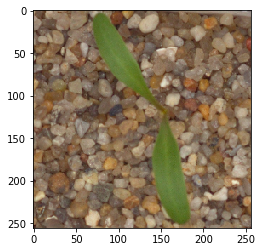

In [9]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [10]:
# Exploring the number of images per species.
label_df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

,file
species,
Loose_Silky-bent,654
Common_Chickweed,611
Scentless_Mayweed,516
Small-flowered_Cranesbill,496
Fat_Hen,475
Charlock,390
Sugar_beet,385
Cleavers,287
Black-grass,263


In [11]:
# Create a dictionary mapping size of the file to its name
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [12]:
# Turn dictionary into rows and cols
row_sz, col_sz = list(zip(*size_d.values()))

row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

# row_sz[:5]

(array([ 2604.,   897.,   215.,    59.,    13.,     4.,     3.,     3.,     0.,     2.]),
 array([   49. ,   443.2,   837.4,  1231.6,  1625.8,  2020. ,  2414.2,  2808.4,  3202.6,  3596.8,  3991. ]),
 <a list of 10 Patch objects>)

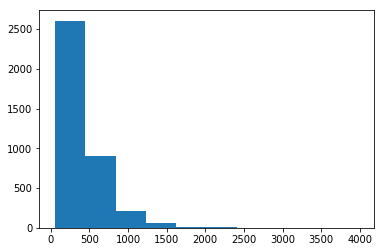

In [13]:
plt.hist(row_sz)

(array([ 1008.,   832.,   269.,   431.,   371.,   261.,   193.,   109.,    80.,    64.]),
 array([  49.,  144.,  239.,  334.,  429.,  524.,  619.,  714.,  809.,  904.,  999.]),
 <a list of 10 Patch objects>)

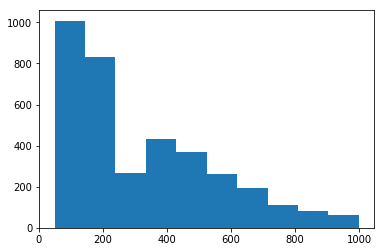

In [14]:
# Grab just images lesser than < 1000px
plt.hist(row_sz[row_sz < 1000])

(array([ 1008.,   829.,   269.,   422.,   372.,   267.,   191.,   115.,    78.,    69.]),
 array([  49. ,  143.4,  237.8,  332.2,  426.6,  521. ,  615.4,  709.8,  804.2,  898.6,  993. ]),
 <a list of 10 Patch objects>)

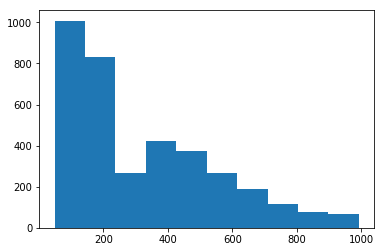

In [15]:
# The same for cols
plt.hist(col_sz[col_sz < 1000])

In [16]:
# Number of training and test images
len(data.trn_ds), len(data.test_ds)

(3800, 794)

## Training

### Start training with small images 64x64

In [17]:
sz = 64
data = get_data(sz)

# resize data for future use (create also new folder tmp to store resized images)
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      4.746014   345.957581 0.170043  



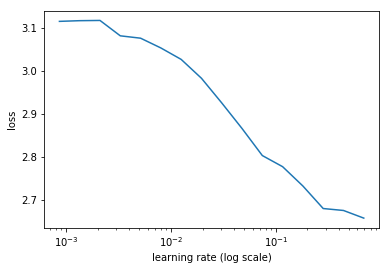

In [19]:
lrf=learn.lr_find()
learn.sched.plot()

In [20]:
lr = 0.2

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.120437   1.392874   0.51876   
    1      1.978633   1.33539    0.554608                 
    2      1.657033   1.105492   0.622197                 
    3      1.51809    1.164497   0.596479                 
    4      1.382714   1.026989   0.642383                 
    5      1.27436    0.981591   0.664585                 
    6      1.168      0.973386   0.665077                 



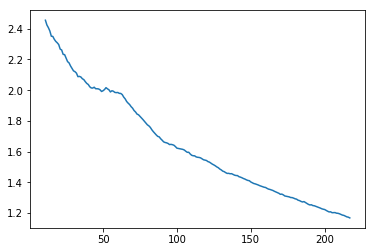

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [22]:
lrs = np.array([lr/9,lr/3,lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.178872   1.206463   0.589816  
    1      0.933066   0.669604   0.763867                  
    2      0.691054   0.365259   0.871361                  
    3      0.603974   0.677774   0.761925                  
    4      0.499392   0.414529   0.861748                  
    5      0.410346   0.283664   0.896071                  
    6      0.333452   0.251057   0.909176                  



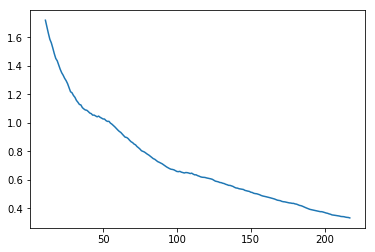

In [23]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [24]:
# learn.save(f'{PATH}resnet_50_64')

#### Change size to 128 x 128

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.254541   0.199934   0.927862  
    1      0.210193   0.169214   0.936959                  
    2      0.180309   0.17454    0.931894                  
    3      0.176689   0.188564   0.933419                  
    4      0.170253   0.167212   0.936467                  
    5      0.16085    0.145724   0.951588                  
    6      0.155121   0.148909   0.944532                  



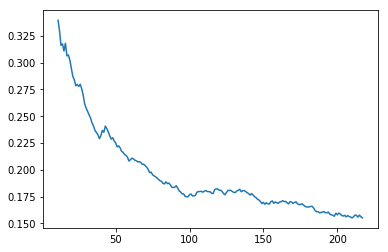

In [39]:
sz=128

learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.197165   0.15158    0.94045   
    1      0.175804   0.162545   0.941508                  
    2      0.152008   0.110961   0.959677                  
    3      0.137147   0.199431   0.929927                  
    4      0.139523   0.12876    0.951072                  
    5      0.116553   0.093862   0.968725                  
    6      0.091412   0.087279   0.968725                   



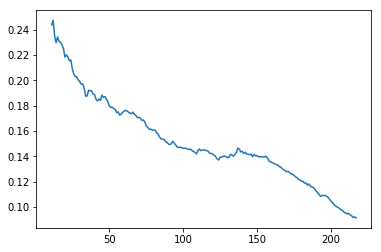

In [40]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
# learn.save(f'{PATH}resnet_50_128')
learn.sched.plot_loss()

#### Change size to 256 x 256

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.158131   0.139201   0.948564  
    1      0.127047   0.112306   0.960661                  
    2      0.115596   0.113216   0.958645                  
    3      0.110188   0.117463   0.963685                  
    4      0.10453    0.106006   0.959653                  
    5      0.09297    0.104755   0.960661                   
    6      0.083011   0.102496   0.963685                   



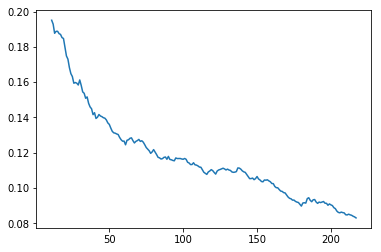

In [41]:
sz=256

learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.036576   0.065065   0.980822  
    1      0.047497   0.146603   0.948072                   
    2      0.052873   0.077072   0.979839                   
    3      0.047051   0.061592   0.979839                   
    4      0.057507   0.195161   0.945024                   
    5      0.072229   0.184658   0.949572                   
    6      0.079378   0.597646   0.852183                   
    7      0.078609   0.130591   0.955596                   
    8      0.066196   0.070721   0.98033                    
    9      0.051743   0.074443   0.97679                    
    10     0.039765   0.06212    0.980847                   
    11     0.029939   0.060393   0.983871                   
    12     0.025222   0.061714   0.981855                   



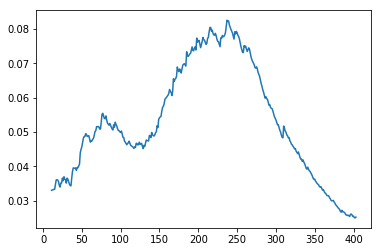

In [43]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=3)
learn.save(f'resnet_50_256')
learn.sched.plot_loss()

#### Change size to 299 x 299

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.026787   0.051975   0.979839  
    1      0.024119   0.050177   0.981855                   
    2      0.024595   0.05096    0.983871                   
    3      0.026753   0.050534   0.983871                   
    4      0.02403    0.053983   0.983871                   
    5      0.024452   0.049492   0.982863                   
    6      0.024086   0.049595   0.981855                   
    7      0.02281    0.050298   0.983871                   
    8      0.022939   0.048396   0.983871                   
    9      0.021182   0.048696   0.984879                   
    10     0.02126    0.049296   0.983871                   
    11     0.02001    0.048871   0.983871                   
    12     0.018253   0.048233   0.983871                   



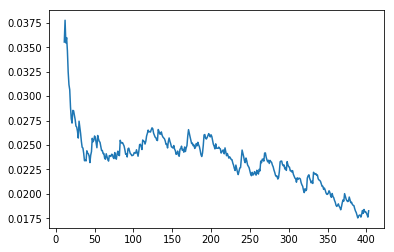

In [44]:
sz=299

# Change lr
lr = np.array([lr/18,lr/6,lr/2])

learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=3)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.03572    0.077102   0.979322  
    1      0.056447   0.331725   0.906201                   
    2      0.060586   0.078246   0.975782                   
    3      0.046867   0.053518   0.984879                   
    4      0.053059   0.345427   0.913233                   
    5      0.061932   0.14972    0.951564                   
    6      0.05976    0.187291   0.941975                   
    7      0.066286   0.236089   0.938926                   
    8      0.054621   0.159093   0.945048                   
    9      0.04439    0.085499   0.971258                   
    10     0.035889   0.049767   0.986379                   
    11     0.029023   0.048131   0.985887                   
    12     0.023278   0.048991   0.985887                   



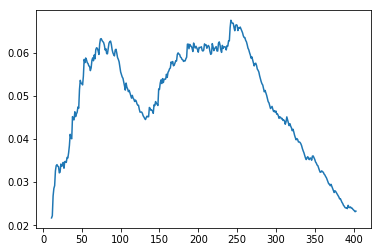

In [45]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=3)
learn.save(f'resnet_50_299')
learn.sched.plot_loss()

In [46]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

(accuracy_np(preds,y), metrics.log_loss(y, preds))
# preds.shape, y.shape
# (0.9810526315789474, 2.4849066734313965)

(0.98736842105263156, 2.4849066734313965)

### Prediction and submition

In [47]:
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

(794, 12)

In [48]:
# replace _ by " " for submition
#label_df.species = label_df.species.apply(lambda x: re.sub(' ', '_', x))

log_preds_test = np.argmax(log_preds_test, axis=1)
preds_classes = [data.classes[i].replace("_", " ") for i in log_preds_test]
probs = np.exp(log_preds_test)


submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv('data/plants/submission_resnet50.csv', index=False)

In [49]:
from IPython.display import FileLink
FileLink('data/plants/submission_resnet50.csv')

/home/paperspace/fastai/courses/dl1/data/plants/submission_resnet50.csv

In [38]:
submission.head(5)

,file,species
0,79e5ea8fa.png,Common wheat
1,3a909ead8.png,Small-flowered Cranesbill
2,599691cd9.png,Small-flowered Cranesbill
3,5ca2687a4.png,Maize
4,3dd52bd2a.png,Small-flowered Cranesbill


### Give us score of 0.97858